## 局部多项式回归
---
* 将结合题一（摩托车事故mcycle数据集）进行阐述
* 概述：局部多项式回归是一种非线性的回归模型，基于核函数加权进行最小二乘法处理局部数据的思路，对每个样本点，在其前后选取窗口做区间的线性回归，从而可以较好的处理呈非线性关系的数据

* 局部多项式回归将对如下的要点进行说明：
  1. **核心思想**——核函数加权+最小二乘法处理局部数据：类似kmeans，以点为单位，给周围的点加权，在利用最小二乘法来估计该点的值，使得原始的数据可以逐步变得平滑，通俗的理解是，原始的数据集可以视为过拟合的，于是通过不断地将点与周围的点进行计算，使得数据之间的联系更为平滑，从而提高模型的泛用性,如图一：<img src="picture1.png" alt="Drawing" style="width: 50%;" align="center"/>
  2. **具体过程**：首先对选定窗区间$x\in N_i$内的数据，采用核函数赋权重,使得离当前点$x_i$越近的点对$x_i$的影响越大，即权重越大，离当前点$x_i$越远的点对$x_i$的影响越小，即权重越小，这里采用了高斯核函数，$\sigma$为超参数，用于控制权重的影响：$$ K(x_j,x_i)=K(||x_j-x_i||)=e^{-\frac{(x_j-x_i)^2}{2 \sigma^2}},即w_j=\frac{e^{-\frac{(x_j-x_i)^2}{2 \sigma^2}}}{\sqrt{2\pi}\sigma}$$
  接着，确定局部多项式回归的多项式模型,这里使用的多项式模型为：$$f(x)=\sum_{n=1}^{N} a_nf_n(x)=a_1f_1(x)+a_2f_2(x)+...+a_nf_n(x)=\sum_{n=1}^{N}a_nx^n$$
  最后对数据进行加权最小二乘法求得参数：$$\underset{a_n(x_i)}{argmin}f(x)=\sum_{j\in N_i}W_j[y_j-\sum^N_{i=1}a_n(x_i)x_j^n]^2$$
  3. **窗宽的影响**：窗宽决定了当前点受周围点影响的范围，窗宽变大时，会缩小局部范围内趋势的变化，使得模型向欠拟合方向变化，窗宽变小时，当前点位置的参数会更聚焦于局部范围内的变化，使得模型向过拟合方向变化，如图二，窗宽为3，极小的时候，模型呈严重的过拟合状态，为50，极大的时候，模型呈严重的欠拟合状态，因此需要寻找到合适的窗宽，实践中可以考虑网格搜索最佳的窗宽超参数。
  <img src="picture2.png" alt="Drawing" style="width: 60%;" align="center"/>
  4. **核函数的选取**：核函数的作用是处理加权最小二乘法中的加权部分，不同的核函数对数据的加权不同，对于这里处理的少量一维的mcycle数据集，采用局部性较强的高斯核函数效果较好，在遇到需要加速计算的时候，可以使用计算相对较快的$Expanechnikov ：\frac{3}{4}(1-u^2)I(|u|<=1)$
  <img src="picture3.png" alt="Drawing" style="width: 50%;" align="center"/>

In [1]:
import matplotlib as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
df=pd.read_csv('mcycle.csv')
df['accel']=df[['accel']].apply(max_min_scaler)
x=df['times'].values
y=df['accel'].values

In [3]:
def local_polynomial_regression(y,x,width,sig):
    kernel=lambda x,c,sig: np.exp(-(x-x[c])**2/(2*(sig**2)))/(np.sqrt(2*np.pi)*sig) #高斯核
    for i in range(len(x)):
        #取得范围内的x,y
        x_window=x[max(0,i-width):min(len(x),i+width)]
        y_window=y[max(0,i-width):min(len(x),i+width)]
        weight=kernel(x,i,sig)#核加权
        weight_window=weight[max(0,i-width):min(len(x),i+width)]
        W=np.diag(weight_window)#将权重转化为斜对角矩阵
        
        #加权最小二乘法寻找最佳参数
        design_matrix=np.asmatrix(np.ones(len(x_window))).T #初始化
        for k in range(1,3):
            arr=np.asmatrix(np.power(x_window,k)).T #x^n的值
            design_matrix=np.concatenate((design_matrix,arr),axis=1)    
        coef=np.asarray((design_matrix.T*W*design_matrix).I*(design_matrix.T*W*(np.asmatrix(y_window).T)))#最小二乘估算系数
        
        y[i]=coef[2]*x[i]*x[i]+coef[1]*x[i]+coef[0] #多项式为ax^2+b^x+c，用最小二乘获得的最佳系数来计算新的y
    return y 

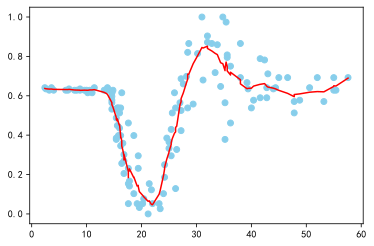

In [4]:
y=local_polynomial_regression(y,x,10,15)
df=pd.read_csv('mcycle.csv')
df['accel']=df[['accel']].apply(max_min_scaler)
plt.scatter(df['times'].values,df['accel'].values,c='skyblue')
plt.plot(x,y,c='r')
plt.show()

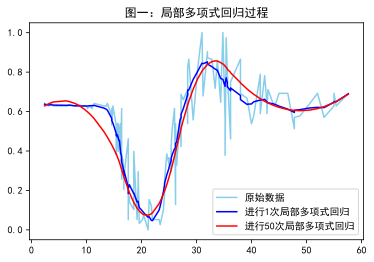

In [5]:
#作图一
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
df=pd.read_csv('mcycle.csv')
df['accel']=df[['accel']].apply(max_min_scaler)
x=df['times'].values
y=df['accel'].values
plt.title("图一：局部多项式回归过程")
plt.plot(x,y,c='skyblue')
y=local_polynomial_regression(y,x,10,15)
plt.plot(x,y,c='b')
for i in range(50):
    y=local_polynomial_regression(y,x,10,15)
plt.plot(x,y,c='r')
plt.legend(labels=['原始数据','进行1次局部多项式回归','进行50次局部多项式回归'],loc='lower right')
plt.show()

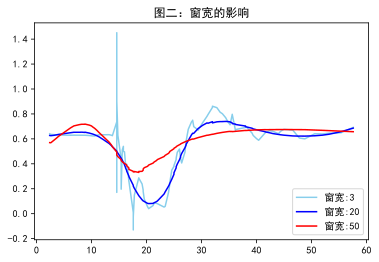

In [6]:
#作图二
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
df=pd.read_csv('mcycle.csv')
df['accel']=df[['accel']].apply(max_min_scaler)
x=df['times'].values
y=df['accel'].values
plt.title("图二：窗宽的影响")
y_noise = y
y=local_polynomial_regression(y,x,3,15)
y=local_polynomial_regression(y,x,3,15)
plt.plot(x,y,c='skyblue')

df=pd.read_csv('mcycle.csv')
df['accel']=df[['accel']].apply(max_min_scaler)
x=df['times'].values
y=df['accel'].values
y_noise = y
y=local_polynomial_regression(y,x,20,15)
y=local_polynomial_regression(y,x,20,15)
plt.plot(x,y,c='b')

df=pd.read_csv('mcycle.csv')
df['accel']=df[['accel']].apply(max_min_scaler)
x=df['times'].values
y=df['accel'].values
y_noise = y
y=local_polynomial_regression(y,x,40,15)
y=local_polynomial_regression(y,x,40,15)
plt.plot(x,y,c='r')
plt.legend(labels=['窗宽:3','窗宽:20','窗宽:50'],loc='lower right')
plt.show()

In [7]:
from sklearn import metrics
df=pd.read_csv('mcycle.csv')
df['accel']=df[['accel']].apply(max_min_scaler)
y_true=df['accel'].values
print(np.sqrt(metrics.mean_squared_error(y_true,y)))

0.16754474843171152


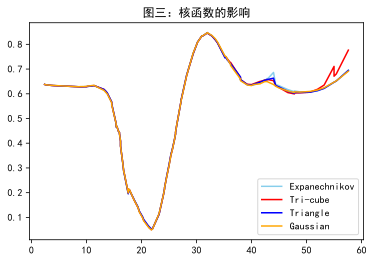

In [8]:
#作图四
#基于多项式模型的加权最小二乘法
def local_polynomial_regression(y,x,width,sig):
    for i in range(len(x)):
        #取得范围内的x,y
        x_window=x[max(0,i-width):min(len(x),i+width)]
        y_window=y[max(0,i-width):min(len(x),i+width)]
        weight=kernel(x,i,sig)#核加权
        weight_window=weight[max(0,i-width):min(len(x),i+width)]
        W=np.diag(weight_window)#将权重转化为斜对角矩阵
        
        #加权最小二乘法寻找最佳参数
        design_matrix=np.asmatrix(np.ones(len(x_window))).T #初始化
        for k in range(1,3):
            arr=np.asmatrix(np.power(x_window,k)).T #x^n的值
            design_matrix=np.concatenate((design_matrix,arr),axis=1)    
        coef=np.asarray((design_matrix.T*W*design_matrix).I*(design_matrix.T*W*(np.asmatrix(y_window).T)))#最小二乘估算系数
        
        y[i]=coef[2]*x[i]*x[i]+coef[1]*x[i]+coef[0] #多项式为ax^2+b^x+c，用最小二乘获得的最佳系数来计算新的y
    return y 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
df=pd.read_csv('mcycle.csv')
df['accel']=df[['accel']].apply(max_min_scaler)
x=df['times'].values
y=df['accel'].values
y_noise = y
plt.title("图三：核函数的影响")
kernel=lambda x,c,sig:(1-((x-x[c])/(sig))**2)*3/4
y=local_polynomial_regression(y,x,8,6)
y=local_polynomial_regression(y,x,8,6)
plt.plot(x,y,c='skyblue')

df=pd.read_csv('mcycle.csv')
df['accel']=df[['accel']].apply(max_min_scaler)
x=df['times'].values
y=df['accel'].values
kernel=lambda x,c,sig:(1-abs(((x-x[c])/(sig))**3))**3
y=local_polynomial_regression(y,x,8,6)
y=local_polynomial_regression(y,x,8,6)
plt.plot(x,y,c='r')

df=pd.read_csv('mcycle.csv')
df['accel']=df[['accel']].apply(max_min_scaler)
x=df['times'].values
y=df['accel'].values
kernel=lambda x,c,sig:1-abs((x-x[c])/(sig))
y=local_polynomial_regression(y,x,8,6)
y=local_polynomial_regression(y,x,8,6)
plt.plot(x,y,c='b')

df=pd.read_csv('mcycle.csv')
df['accel']=df[['accel']].apply(max_min_scaler)
x=df['times'].values
y=df['accel'].values
kernel=lambda x,c,sig:np.exp(-(x-x[c])**2/(2*(sig**2)))/(np.sqrt(2*np.pi)*sig)
y=local_polynomial_regression(y,x,8,6)
y=local_polynomial_regression(y,x,8,6)
plt.plot(x,y,c='orange')

plt.legend(labels=['Expanechnikov','Tri-cube','Triangle','Gaussian'],loc='lower right')
plt.show()